## Review of Dalal & Triggs Paper 'Histogram of Oriented Gradients for Human Detection'

#### Abstract

- Histogram of Oriented Gradients
    - Fine-scale gradients
    - Fine orientation binning
    - Coarse orientation binning
    - High-quality local contrast normalization

#### 1. Introduction

- Linear SVM is baseline classifier
- MIT pedestrian test set


1. Introduction
2. Previous work
3. Method overview
4. Describe dataset
5. Detailed description of process
7. Conclusions

#### 2. Previous work

Relevant papers on human detection:
- Polynomial SVM w/ rectified Haar wavelets
- Edge-based classification
- AdaBoost on Haar-like wavelets (Viola-Jones)

#### 3. Method overview

"Based on evaluating normalized local histograms of image gradient orientations in a dense grid"
- Divide image widow into cells, compute a 1D histogram of gradient directions for each cell
- Invariance to illumination demands normalization
- Normalization is done over groups of cells, called 'blocks'
- Normalized descriptor blocks -> Histogram of Oriented Gradients descriptors
- Tile the detection window with a dense grid of HOG descriptors. Use the combined feature vector.


1. Input image
2. Normalize gamma and colour
3. Compute gradients across entire image
4. Weighted vote into spatial and orientation cells
5. Normalize cell HOGs over each block
6. Collect HOGs over detection window
7. Train Linear SVM against HOGs for people/no-people.

#### 4. Datasets and Method 

Dataset: MIT pedestrian database (509 training, 200 test images)
Method:
1239 positive training examples, reflected (2478 images).
1218 person-free photos, from which 12180 patches were sampled (these patches constituted the negative samples).
Train one detector for each 

#### 5. Implementation

Default detector's properties:
    - RGB with no gamma correction
    - [-1, 0, 1] gradients filter, no smoothing
    - Linear gradient voting into 9 orientation bins in 0-180deg
    - 16x16 pixel blocks
    - Each pixel block contains 4 8x8 cells
    - Gaussian spatial window with sigma=8 (weighting of hists)
    - L2-Hys block normalization (contrast?)
    - Block stride of 8 pixels
    - 64 x 128 detection window (i.e. cropped person size)
    - Linear SVM classifier

Gradient computation:
    - [-1, 0, 1] masks, one for x, one for y

Spatial/Orientation binning:
    - Each pixel calculates a gradient-magnitude-weighted vote for edge orientation histogram channels.
    - The votes are accumulated into orientation bins over a cell
    - 0-180deg orientation bins
    - Histogram votes are interpolated bilinearly between nearest bins for both orientation and magnitude
    - Fine orientation binning (up to 9 bins)
    
Normalization and descriptor blocks:
    - Local contrast normalization is essential
    - Group cells into blocks, normalize each block separately
    - Blocks should overlap
    - 3x3 cell blocks, 6x6 pixel cells
    - Downweighted block edges using a Gaussian spatial window
    - Contast normalization was done using L2-norm 
    - Comments that Linear SVM depends on silhouette contours as cue, as opposed to internal conto
        - Their SVM weighted the head and the gap between the legs most heavily.
    - Context was important (they included a 16px min. border around people - removing this degraded performance)
    

## Replicating their results

#### Histograms of Oriented Gradients

1. Use a single-channel image (i.e. grayscale)
2. Compute x, y, gradients for entire image.
    - Get L2 norm (i.e. gradient magnitude)
    - Get orientation 
3. Calculate a magnitude-weighted vote for an edge orientation at each pixel.
4. Accumulate these votes into a histogram for a cell (6x6 px). The histogram has 9 bins between 0 an 180 degrees (orientation is unsigned). Distribute votes from pixels whose orientations aren't in bin centers proportionally between adjacent bins.
7. The final descriptor is a vector of each cell's histogram components from all blocks in the detection window (the detection window being the 64x128 image in this case).

In [1]:
from scipy.ndimage import imread
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
import cv2
%matplotlib inline

## 1. Import Data

#### Positive samples

Retrieved from http://cbcl.mit.edu/software-datasets/PedestrianData.html

In [14]:
def ppm_to_jpg():
    ppm_fps = glob.glob('./data/ppm/*')
    for fp in ppm_fps:
        img_name = fp.split('\\')[-1][:-4]
        with Image.open(fp) as img:
            img.save('./data/jpg/%s.jpg' % img_name)

In [2]:
pos_fps = glob.glob('./data/jpg/*')
pos_imgs = np.array([imread(img_fp) for img_fp in pos_fps])
pos_imgs.shape # All images are 64x128 (w, h)

(924, 128, 64, 3)

#### Negative samples

Subsampled from negative training samples of http://pascal.inrialpes.fr/data/human/

In [3]:
neg_fps = glob.glob('./data/INRIAPerson/Train/neg/*')
neg_imgs = np.array([imread(img_fp) for img_fp in neg_fps])

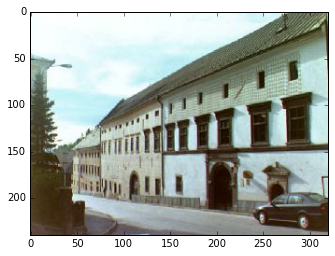

In [4]:
# Extract 64x128 subsamples from these images (~ 10k - 15k)
plt.imshow(neg_imgs[42]);

## 2. Histogram of Gradients

In [ ]:
# 1. Get image gradients
# 2. Compute gradient magnitudes
# 3. Compute unsigned gradient orientations

In [61]:
def max_channel_mask(a): # For getting the maximum pixels from a 3D image
    z = np.zeros(a.shape[:2])
    comparator = np.expand_dims(np.argmax(a, axis=2), axis=2)
    mask = (np.stack([z, z+1, z+2], axis=2) == comparator)
    return mask

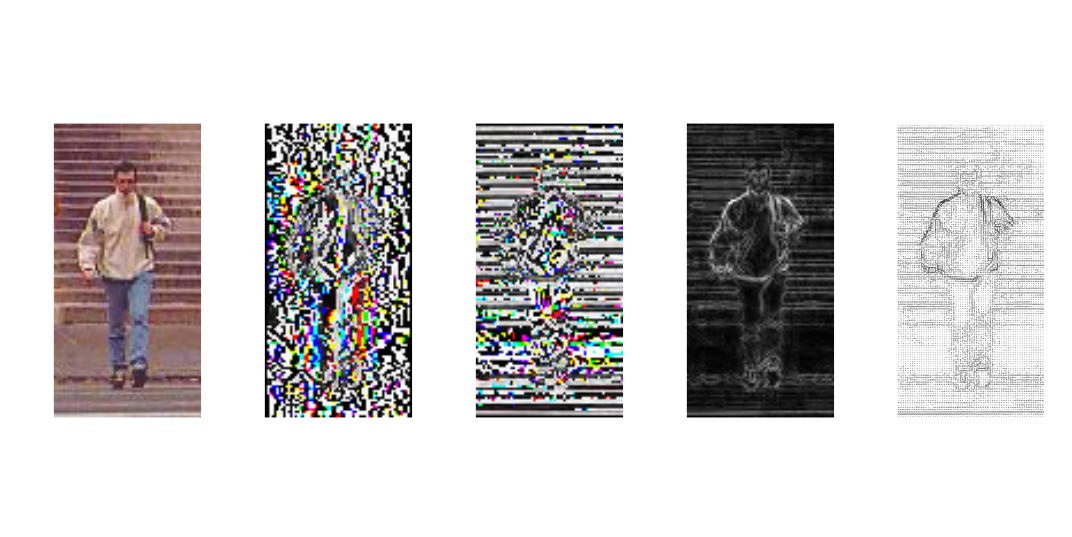

In [130]:
sample_img = pos_imgs[31]

xfilter = np.array([[-1, 0, 1]])
yfilter = xfilter.T
xgradients = cv2.filter2D(sample_img.copy().astype('float32'), -1, xfilter)
ygradients = cv2.filter2D(sample_img.copy().astype('float32'), -1, yfilter)
gradmag = np.sqrt(xgradients**2 + ygradients**2) # Take pixels from channel with largest gradient
grador = np.arctan(np.divide(xgradients, ygradients+.00001))# Angle relative to  vertical in radians
mask = max_channel_mask(gradmag)
grador = (grador*mask).sum(axis=2)
gradmag = (gradmag*mask).sum(axis=2)

# For the quiver plot
Y, X = np.mgrid[0:grador.shape[0], 0:grador.shape[1]]
U = gradmag*np.cos(grador) # x component
V = gradmag*np.sin(grador) # y component

_, axs = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(15, 7.5))

axs[0].imshow(sample_img); axs[1].imshow(xgradients, cmap='gray'); 
axs[2].imshow(ygradients, cmap='gray'); axs[3].imshow(gradmag, cmap='gray');
plt.quiver(X, Y, U, V, gradmag, headwidth=3, headlength=3, pivot='mid', cmap='Greys', axes=axs[4], lw=.15);
_ = [ax.axis('off') for ax in axs]; plt.tight_layout();

In [ ]:
# Next: histogram of these gradients in 6x6px cells. 9 bins, -pi/2 to pi/2. Split votes proportionally between adjacent bins.
# After that: Normalize histograms over overlapping blocks (l2 normalized).
# After that: A vector combining every cell's response for each block - this is the feature vector for the SVM.
# After that: Subsample negative samples, save these.
# After that: Train linear SVM against HOG vectors.